In [14]:
import base64
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
    
# Source: Intro to AI, Session 6 (City, University of London)
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Source: Intro to AI, Session 6 (City, University of London)
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    if target_type in (np.int64, np.int32):
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Source: Intro to AI, Session 6 (City, University of London)
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

path = "."

filename_read = os.path.join(path, "Clean_Dataset.csv")
df = pd.read_csv(filename_read, index_col = 0)

df.isna().sum()

df.head()

flights = df['flight']
df.drop('flight', 1, inplace = True)

# Converting the price from Indian rupees to GBP
df['price'] = (df["price"]*0.011).round(2)

df.head()

C:\Users\kinga\AppData\Local\Temp\ipykernel_11012\2592785080.py:56: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('flight', 1, inplace = True)


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,65.48
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,65.48
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,65.52
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,65.50
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,65.50


In [15]:
# Label encoding to ensure the dataset does not contain any string values
encode_text_index(df, "airline")
encode_text_index(df, "source_city")
encode_text_index(df, "departure_time")
encode_text_index(df, "arrival_time")
encode_text_index(df, "destination_city")
encode_text_index(df, "class")

# Match and replace the numerical values in text with integers
df['stops'] = df['stops'].replace(["zero", "one", "two_or_more"], [0, 1, 2])
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,2,0,5,5,1,2.17,1,65.48
1,4,2,1,0,4,5,1,2.33,1,65.48
2,0,2,1,0,1,5,1,2.17,1,65.52
3,5,2,4,0,0,5,1,2.25,1,65.50
4,5,2,4,0,4,5,1,2.33,1,65.50


In [16]:
X,y = to_xy(df, "price")

print(y.shape)
print(y[0:5])

(300153, 1)
[[65.48]
 [65.48]
 [65.52]
 [65.5 ]
 [65.5 ]]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=X[1].shape, activation='sigmoid')) # Hidden layer
model.add(Dense(1)) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=10)
model.summary()

# Predict the flight prices
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
print(pred[:10])

# Return the RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Score (RMSE): {score}")

Epoch 1/10
7035/7035 - 18s - loss: 110100.2812 - 18s/epoch - 3ms/step
Epoch 2/10
7035/7035 - 17s - loss: 99068.2109 - 17s/epoch - 2ms/step
Epoch 3/10
7035/7035 - 17s - loss: 89531.7656 - 17s/epoch - 2ms/step
Epoch 4/10
7035/7035 - 17s - loss: 81149.4766 - 17s/epoch - 2ms/step
Epoch 5/10
7035/7035 - 16s - loss: 73515.2188 - 16s/epoch - 2ms/step
Epoch 6/10
7035/7035 - 17s - loss: 66957.5391 - 17s/epoch - 2ms/step
Epoch 7/10
7035/7035 - 17s - loss: 59555.7148 - 17s/epoch - 2ms/step
Epoch 8/10
7035/7035 - 18s - loss: 52175.8398 - 18s/epoch - 3ms/step
Epoch 9/10
7035/7035 - 17s - loss: 45938.2969 - 17s/epoch - 2ms/step
Epoch 10/10
7035/7035 - 17s - loss: 39261.9883 - 17s/epoch - 2ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 40        
                                                                 
 dense_5 (Dense)      

In [18]:
model = Sequential()
model.add(Dense(4, input_dim=X.shape[1], activation='sigmoid')) # Hidden layer
model.add(Dense(1)) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=200)

# Predict the flight prices using the fine tuned model
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
print(pred[:10])

# Return the RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Score (RMSE): {score}")

Epoch 1/200
7035/7035 - 18s - loss: 108304.7422 - 18s/epoch - 3ms/step
Epoch 2/200
7035/7035 - 16s - loss: 97419.7109 - 16s/epoch - 2ms/step
Epoch 3/200
7035/7035 - 17s - loss: 88122.3906 - 17s/epoch - 2ms/step
Epoch 4/200
7035/7035 - 17s - loss: 79811.1406 - 17s/epoch - 2ms/step
Epoch 5/200
7035/7035 - 16s - loss: 71736.9219 - 16s/epoch - 2ms/step
Epoch 6/200
7035/7035 - 17s - loss: 64445.9961 - 17s/epoch - 2ms/step
Epoch 7/200
7035/7035 - 17s - loss: 57846.0938 - 17s/epoch - 2ms/step
Epoch 8/200
7035/7035 - 17s - loss: 51690.2930 - 17s/epoch - 2ms/step
Epoch 9/200
7035/7035 - 17s - loss: 45945.8477 - 17s/epoch - 2ms/step
Epoch 10/200
7035/7035 - 17s - loss: 40743.3008 - 17s/epoch - 2ms/step
Epoch 11/200
7035/7035 - 17s - loss: 36039.5938 - 17s/epoch - 2ms/step
Epoch 12/200
7035/7035 - 17s - loss: 30152.4355 - 17s/epoch - 2ms/step
Epoch 13/200
7035/7035 - 17s - loss: 25615.0410 - 17s/epoch - 2ms/step
Epoch 14/200
7035/7035 - 17s - loss: 21779.4531 - 17s/epoch - 2ms/step
Epoch 15/200
7

Epoch 118/200
7035/7035 - 14s - loss: 4135.0566 - 14s/epoch - 2ms/step
Epoch 119/200
7035/7035 - 14s - loss: 4132.2808 - 14s/epoch - 2ms/step
Epoch 120/200
7035/7035 - 14s - loss: 4132.4897 - 14s/epoch - 2ms/step
Epoch 121/200
7035/7035 - 15s - loss: 4129.6528 - 15s/epoch - 2ms/step
Epoch 122/200
7035/7035 - 14s - loss: 4128.6758 - 14s/epoch - 2ms/step
Epoch 123/200
7035/7035 - 14s - loss: 4129.9624 - 14s/epoch - 2ms/step
Epoch 124/200
7035/7035 - 17s - loss: 4126.2495 - 17s/epoch - 2ms/step
Epoch 125/200
7035/7035 - 14s - loss: 4127.9312 - 14s/epoch - 2ms/step
Epoch 126/200
7035/7035 - 16s - loss: 4124.4893 - 16s/epoch - 2ms/step
Epoch 127/200
7035/7035 - 15s - loss: 4123.9185 - 15s/epoch - 2ms/step
Epoch 128/200
7035/7035 - 14s - loss: 4123.5244 - 14s/epoch - 2ms/step
Epoch 129/200
7035/7035 - 16s - loss: 4121.6812 - 16s/epoch - 2ms/step
Epoch 130/200
7035/7035 - 14s - loss: 4121.5283 - 14s/epoch - 2ms/step
Epoch 131/200
7035/7035 - 14s - loss: 4118.5171 - 14s/epoch - 2ms/step
Epoch 

In [19]:
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='sigmoid')) # Hidden layer 1
model.add(Dense(1)) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=200)

# Predict the flight prices using the fine tuned model
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
print(pred[:10])

# Return the RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Score (RMSE): {score}")

Epoch 1/200
7035/7035 - 10s - loss: 83728.0078 - 10s/epoch - 1ms/step
Epoch 2/200
7035/7035 - 9s - loss: 39816.5898 - 9s/epoch - 1ms/step
Epoch 3/200
7035/7035 - 9s - loss: 12572.3906 - 9s/epoch - 1ms/step
Epoch 4/200
7035/7035 - 9s - loss: 4912.6909 - 9s/epoch - 1ms/step
Epoch 5/200
7035/7035 - 9s - loss: 4080.5408 - 9s/epoch - 1ms/step
Epoch 6/200
7035/7035 - 9s - loss: 3927.7424 - 9s/epoch - 1ms/step
Epoch 7/200
7035/7035 - 9s - loss: 3822.7671 - 9s/epoch - 1ms/step
Epoch 8/200
7035/7035 - 9s - loss: 3764.8711 - 9s/epoch - 1ms/step
Epoch 9/200
7035/7035 - 9s - loss: 3719.2947 - 9s/epoch - 1ms/step
Epoch 10/200
7035/7035 - 9s - loss: 3678.3206 - 9s/epoch - 1ms/step
Epoch 11/200
7035/7035 - 9s - loss: 3650.4934 - 9s/epoch - 1ms/step
Epoch 12/200
7035/7035 - 9s - loss: 3612.0935 - 9s/epoch - 1ms/step
Epoch 13/200
7035/7035 - 9s - loss: 3569.7585 - 9s/epoch - 1ms/step
Epoch 14/200
7035/7035 - 9s - loss: 3542.2754 - 9s/epoch - 1ms/step
Epoch 15/200
7035/7035 - 9s - loss: 3519.3730 - 9s/e

Epoch 121/200
7035/7035 - 9s - loss: 3113.6575 - 9s/epoch - 1ms/step
Epoch 122/200
7035/7035 - 9s - loss: 3113.4883 - 9s/epoch - 1ms/step
Epoch 123/200
7035/7035 - 9s - loss: 3110.3320 - 9s/epoch - 1ms/step
Epoch 124/200
7035/7035 - 9s - loss: 3102.1414 - 9s/epoch - 1ms/step
Epoch 125/200
7035/7035 - 9s - loss: 3090.5508 - 9s/epoch - 1ms/step
Epoch 126/200
7035/7035 - 9s - loss: 3084.9438 - 9s/epoch - 1ms/step
Epoch 127/200
7035/7035 - 9s - loss: 3081.3572 - 9s/epoch - 1ms/step
Epoch 128/200
7035/7035 - 9s - loss: 3078.8738 - 9s/epoch - 1ms/step
Epoch 129/200
7035/7035 - 9s - loss: 3076.9568 - 9s/epoch - 1ms/step
Epoch 130/200
7035/7035 - 9s - loss: 3074.5642 - 9s/epoch - 1ms/step
Epoch 131/200
7035/7035 - 9s - loss: 3071.9778 - 9s/epoch - 1ms/step
Epoch 132/200
7035/7035 - 9s - loss: 3069.5024 - 9s/epoch - 1ms/step
Epoch 133/200
7035/7035 - 9s - loss: 3068.5872 - 9s/epoch - 1ms/step
Epoch 134/200
7035/7035 - 9s - loss: 3065.4324 - 9s/epoch - 1ms/step
Epoch 135/200
7035/7035 - 9s - los

In [20]:
model = Sequential()
model.add(Dense(1024, input_dim=X.shape[1], activation='sigmoid')) # Hidden layer
model.add(Dense(1)) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=200)

# Predict the flight prices using the fine tuned model
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
print(pred[:10])

# Return the RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Score (RMSE): {score}")

Epoch 1/200
7035/7035 - 12s - loss: 13523.7354 - 12s/epoch - 2ms/step
Epoch 2/200
7035/7035 - 11s - loss: 4298.0059 - 11s/epoch - 2ms/step
Epoch 3/200
7035/7035 - 12s - loss: 3823.2200 - 12s/epoch - 2ms/step
Epoch 4/200
7035/7035 - 12s - loss: 3658.8706 - 12s/epoch - 2ms/step
Epoch 5/200
7035/7035 - 11s - loss: 3570.4480 - 11s/epoch - 2ms/step
Epoch 6/200
7035/7035 - 11s - loss: 3491.7637 - 11s/epoch - 2ms/step
Epoch 7/200
7035/7035 - 14s - loss: 3425.1570 - 14s/epoch - 2ms/step
Epoch 8/200
7035/7035 - 11s - loss: 3364.1411 - 11s/epoch - 2ms/step
Epoch 9/200
7035/7035 - 14s - loss: 3320.9187 - 14s/epoch - 2ms/step
Epoch 10/200
7035/7035 - 13s - loss: 3282.5789 - 13s/epoch - 2ms/step
Epoch 11/200
7035/7035 - 12s - loss: 3247.8774 - 12s/epoch - 2ms/step
Epoch 12/200
7035/7035 - 13s - loss: 3211.9099 - 13s/epoch - 2ms/step
Epoch 13/200
7035/7035 - 12s - loss: 3176.3359 - 12s/epoch - 2ms/step
Epoch 14/200
7035/7035 - 12s - loss: 3146.8679 - 12s/epoch - 2ms/step
Epoch 15/200
7035/7035 - 13s

Epoch 118/200
7035/7035 - 11s - loss: 1870.5941 - 11s/epoch - 2ms/step
Epoch 119/200
7035/7035 - 11s - loss: 1867.0309 - 11s/epoch - 2ms/step
Epoch 120/200
7035/7035 - 11s - loss: 1862.0583 - 11s/epoch - 2ms/step
Epoch 121/200
7035/7035 - 11s - loss: 1858.4764 - 11s/epoch - 2ms/step
Epoch 122/200
7035/7035 - 11s - loss: 1855.6713 - 11s/epoch - 2ms/step
Epoch 123/200
7035/7035 - 11s - loss: 1849.3140 - 11s/epoch - 2ms/step
Epoch 124/200
7035/7035 - 11s - loss: 1846.0620 - 11s/epoch - 2ms/step
Epoch 125/200
7035/7035 - 11s - loss: 1842.4696 - 11s/epoch - 2ms/step
Epoch 126/200
7035/7035 - 11s - loss: 1838.7084 - 11s/epoch - 1ms/step
Epoch 127/200
7035/7035 - 11s - loss: 1834.0243 - 11s/epoch - 2ms/step
Epoch 128/200
7035/7035 - 11s - loss: 1830.9355 - 11s/epoch - 2ms/step
Epoch 129/200
7035/7035 - 12s - loss: 1827.9575 - 12s/epoch - 2ms/step
Epoch 130/200
7035/7035 - 18s - loss: 1822.8663 - 18s/epoch - 3ms/step
Epoch 131/200
7035/7035 - 14s - loss: 1818.0260 - 14s/epoch - 2ms/step
Epoch 

In [21]:
model = Sequential()
model.add(Dense(1024, input_dim=X.shape[1], activation='relu')) # Hidden layer
model.add(Dense(1)) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=200)

# Predict the flight prices using the fine tuned model
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
print(pred[:10])

# Return the RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Score (RMSE): {score}")

Epoch 1/200
7035/7035 - 19s - loss: 10166.6963 - 19s/epoch - 3ms/step
Epoch 2/200
7035/7035 - 15s - loss: 3662.0879 - 15s/epoch - 2ms/step
Epoch 3/200
7035/7035 - 11s - loss: 3509.7539 - 11s/epoch - 2ms/step
Epoch 4/200
7035/7035 - 11s - loss: 3395.0059 - 11s/epoch - 2ms/step
Epoch 5/200
7035/7035 - 11s - loss: 3318.4438 - 11s/epoch - 2ms/step
Epoch 6/200
7035/7035 - 11s - loss: 3257.0442 - 11s/epoch - 2ms/step
Epoch 7/200
7035/7035 - 11s - loss: 3219.1873 - 11s/epoch - 2ms/step
Epoch 8/200
7035/7035 - 11s - loss: 3185.2083 - 11s/epoch - 2ms/step
Epoch 9/200
7035/7035 - 12s - loss: 3150.2788 - 12s/epoch - 2ms/step
Epoch 10/200
7035/7035 - 14s - loss: 3126.3289 - 14s/epoch - 2ms/step
Epoch 11/200
7035/7035 - 12s - loss: 3105.9253 - 12s/epoch - 2ms/step
Epoch 12/200
7035/7035 - 18s - loss: 3077.1250 - 18s/epoch - 3ms/step
Epoch 13/200
7035/7035 - 12s - loss: 3053.4587 - 12s/epoch - 2ms/step
Epoch 14/200
7035/7035 - 11s - loss: 3018.3582 - 11s/epoch - 2ms/step
Epoch 15/200
7035/7035 - 11s

Epoch 118/200
7035/7035 - 10s - loss: 2110.7896 - 10s/epoch - 1ms/step
Epoch 119/200
7035/7035 - 10s - loss: 2106.0923 - 10s/epoch - 1ms/step
Epoch 120/200
7035/7035 - 11s - loss: 2104.1472 - 11s/epoch - 2ms/step
Epoch 121/200
7035/7035 - 11s - loss: 2099.8484 - 11s/epoch - 2ms/step
Epoch 122/200
7035/7035 - 11s - loss: 2101.5112 - 11s/epoch - 2ms/step
Epoch 123/200
7035/7035 - 11s - loss: 2096.8933 - 11s/epoch - 2ms/step
Epoch 124/200
7035/7035 - 11s - loss: 2093.2898 - 11s/epoch - 2ms/step
Epoch 125/200
7035/7035 - 11s - loss: 2091.5576 - 11s/epoch - 2ms/step
Epoch 126/200
7035/7035 - 11s - loss: 2086.7566 - 11s/epoch - 2ms/step
Epoch 127/200
7035/7035 - 11s - loss: 2085.9326 - 11s/epoch - 1ms/step
Epoch 128/200
7035/7035 - 10s - loss: 2083.5107 - 10s/epoch - 1ms/step
Epoch 129/200
7035/7035 - 10s - loss: 2083.2539 - 10s/epoch - 1ms/step
Epoch 130/200
7035/7035 - 10s - loss: 2081.3293 - 10s/epoch - 1ms/step
Epoch 131/200
7035/7035 - 10s - loss: 2076.0271 - 10s/epoch - 1ms/step
Epoch 

In [22]:
model = Sequential()
model.add(Dense(1024, input_dim=X.shape[1], activation='relu')) # Hidden layer one
model.add(Dense(1024,activation='relu')) # Hidden layer two
model.add(Dense(1)) # Output layer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train,verbose=2,epochs=200)

# Predict the flight prices using the fine tuned model
pred = model.predict(X_test)
print("Shape: {}".format(pred.shape))
print(pred[:10])

# Return the RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Score (RMSE): {score}")

Epoch 1/200
7035/7035 - 101s - loss: 5416.1050 - 101s/epoch - 14ms/step
Epoch 2/200
7035/7035 - 112s - loss: 3403.6223 - 112s/epoch - 16ms/step
Epoch 3/200
7035/7035 - 100s - loss: 3192.4973 - 100s/epoch - 14ms/step
Epoch 4/200
7035/7035 - 100s - loss: 3044.6787 - 100s/epoch - 14ms/step
Epoch 5/200
7035/7035 - 85s - loss: 2950.9846 - 85s/epoch - 12ms/step
Epoch 6/200
7035/7035 - 94s - loss: 2862.3032 - 94s/epoch - 13ms/step
Epoch 7/200
7035/7035 - 100s - loss: 2761.2434 - 100s/epoch - 14ms/step
Epoch 8/200
7035/7035 - 100s - loss: 2678.3726 - 100s/epoch - 14ms/step
Epoch 9/200
7035/7035 - 100s - loss: 2600.5815 - 100s/epoch - 14ms/step
Epoch 10/200
7035/7035 - 97s - loss: 2521.0398 - 97s/epoch - 14ms/step
Epoch 11/200
7035/7035 - 99s - loss: 2444.3801 - 99s/epoch - 14ms/step
Epoch 12/200
7035/7035 - 98s - loss: 2379.7915 - 98s/epoch - 14ms/step
Epoch 13/200
7035/7035 - 99s - loss: 2328.2046 - 99s/epoch - 14ms/step
Epoch 14/200
7035/7035 - 90s - loss: 2270.4910 - 90s/epoch - 13ms/step
E

Epoch 115/200
7035/7035 - 104s - loss: 1324.6559 - 104s/epoch - 15ms/step
Epoch 116/200
7035/7035 - 103s - loss: 1320.1437 - 103s/epoch - 15ms/step
Epoch 117/200
7035/7035 - 103s - loss: 1322.6952 - 103s/epoch - 15ms/step
Epoch 118/200
7035/7035 - 104s - loss: 1312.8820 - 104s/epoch - 15ms/step
Epoch 119/200
7035/7035 - 103s - loss: 1312.1432 - 103s/epoch - 15ms/step
Epoch 120/200
7035/7035 - 102s - loss: 1308.3763 - 102s/epoch - 15ms/step
Epoch 121/200
7035/7035 - 105s - loss: 1304.2153 - 105s/epoch - 15ms/step
Epoch 122/200
7035/7035 - 105s - loss: 1304.7721 - 105s/epoch - 15ms/step
Epoch 123/200
7035/7035 - 104s - loss: 1300.0215 - 104s/epoch - 15ms/step
Epoch 124/200
7035/7035 - 105s - loss: 1298.5991 - 105s/epoch - 15ms/step
Epoch 125/200
7035/7035 - 178s - loss: 1295.4346 - 178s/epoch - 25ms/step
Epoch 126/200
7035/7035 - 138s - loss: 1293.0452 - 138s/epoch - 20ms/step
Epoch 127/200
7035/7035 - 129s - loss: 1288.1801 - 129s/epoch - 18ms/step
Epoch 128/200
7035/7035 - 124s - loss:

In [23]:
# Return the final RMSE score of the model
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 36.7406120300293


In [24]:
# Predicted prices
for i in range(20):
    print(f"{i+1}. Flight: {flights[i]}, Price: {y[i]}, predicted price: {pred[i]}")

1. Flight: SG-8709, Price: [65.48], predicted price: [128.54897]
2. Flight: SG-8157, Price: [65.48], predicted price: [735.4303]
3. Flight: I5-764, Price: [65.52], predicted price: [70.641136]
4. Flight: UK-995, Price: [65.5], predicted price: [28.198452]
5. Flight: UK-963, Price: [65.5], predicted price: [58.72788]
6. Flight: UK-945, Price: [65.5], predicted price: [45.365604]
7. Flight: UK-927, Price: [66.66], predicted price: [843.2619]
8. Flight: UK-951, Price: [66.66], predicted price: [742.0858]
9. Flight: G8-334, Price: [65.49], predicted price: [53.26331]
10. Flight: G8-336, Price: [65.49], predicted price: [47.488678]
11. Flight: G8-392, Price: [65.49], predicted price: [529.8487]
12. Flight: G8-338, Price: [65.49], predicted price: [624.17596]
13. Flight: 6E-5001, Price: [65.5], predicted price: [606.13257]
14. Flight: 6E-6202, Price: [65.5], predicted price: [66.35046]
15. Flight: 6E-549, Price: [65.5], predicted price: [94.03111]
16. Flight: 6E-6278, Price: [65.5], predicte

In [25]:
print("Dataset size: {}".format(len(df)))
remove_outliers(df,'price',2) 
print("Dataset size (Dropped)": {}".format(len(df)))

sc = StandardScaler()
sc.fit(X_train)
X_train= sc.transform(X_train)
X_test = sc.transform(X_test)

Length before price outliers dropped: 300153
Length after price outliers dropped: 289222


<AxesSubplot: xlabel='Actual', ylabel='Predicted'>

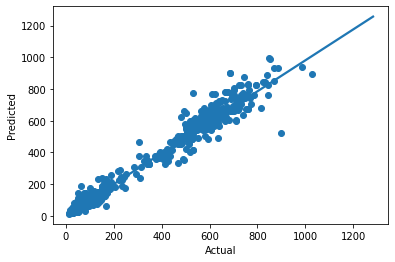

In [27]:
# Scatterplot of actual vs predicted prices
plt.scatter(pred[:1000], y_test[:1000])
plt.xlabel('Actual')
plt.ylabel('Predicted')
sb.regplot(x = y_test, y = pred, scatter = False)